# Calculating GLORYs Climatology 
This notebook calculates and exports the monthly climatology for GLORYs sea surface and bottom temperature AND salinity data. 

This climatology is eventually used as a reference period with the delta method to bias-correct and downscale global climate model projections from experiments run as part of CMIP6. 

To get this started, I run python in a virtual environment, then need to activate the virtual environment (source path/to/venv/bin/activate) and then install any needed packages first.

In [1]:
# Libraries
import xarray as xr
#import cartopy.crs as crs
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
import os

# Set up workspace, paths and dates for the climatology

In [2]:
# Set Workspace:
# workspace = "andrew"
# UsrName = "aallyn"
UsrName = "adamkemberling"
workspace = "local"

# Root paths for sdm_workflows project - local/docker
root_locations = {
  "local" : f"/Users/{UsrName}/Library/CloudStorage/Box-Box/",
  "andrew": "/Users/aallyn/Library/CloudStorage/Box-Box/",
  "docker": "/home/jovyan/"}

# Set root based on workspace
box_root = root_locations[workspace]
print(f"Working via {workspace} directory at: {box_root}")

# Set start and end year for climatology
start_year = 1993
end_year   = 2023

# Path to GLORYs data sources on BOX
glorys_path = {
  "surf_temp"  : f"{box_root}RES_Data/GLORYs/NW_Atl_MonthlyTemps/SST.nc",
  "bot_temp"  : f"{box_root}RES_Data/GLORYs/NW_Atl_MonthlyTemps/BT.nc"}

# key to match variable name to source -- not sure if this is needed?
var_key = {
  "bot_temp"   : "temp",
  "surf_temp"  : "temp"}

Working via local directory at: /Users/adamkemberling/Library/CloudStorage/Box-Box/


# Load data and build xarray datasets

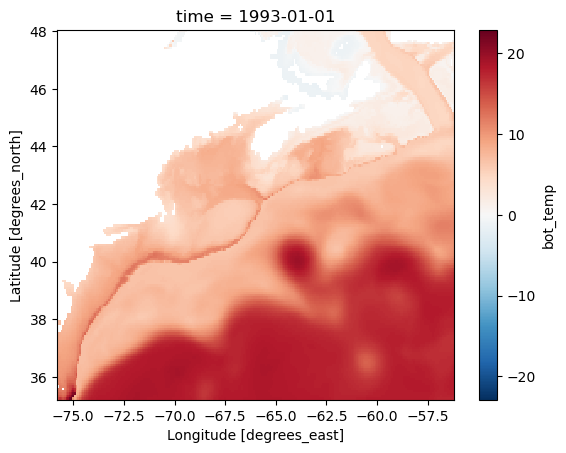

<Figure size 640x480 with 0 Axes>

In [3]:
# # Instead of loop, just put them all together in one...
# surftemp = xr.open_dataset(glorys_path["surf_temp"]).drop_vars("depth")
# surftemp = surftemp.rename_vars({"surface_temp" : "surf_temp"})

# bottemp = xr.open_dataset(glorys_path["bot_temp"]).drop_vars("depth")
# bottemp = bottemp.rename_vars({"bottom_temp" : "bot_temp"})

# # Merge them together
# glorys_manual = xr.merge([surftemp, bottemp])

# # Inspect it
# glorys_full = glorys_manual
# type(glorys_full)

#------------

# Load the temperature and salinity file
glorys_full = xr.open_dataset(f"{box_root}RES_Data/GLORYs/NW_Atl_MonthlyTemps/Surface_Bottom_Monthly_TempSal_to_400m.nc")
glorys_full = glorys_full.rename_vars({
    "surface_temp" : "surf_temp",
    "bottom_temp"  : "bot_temp",
    "surface_so"   : "surf_sal",
    "bottom_so"    : "bot_sal"
})

# plot
glorys_full.bot_temp.isel(time = 0).plot()
plt.show()
plt.clf()

# Climatology calculations and saving output

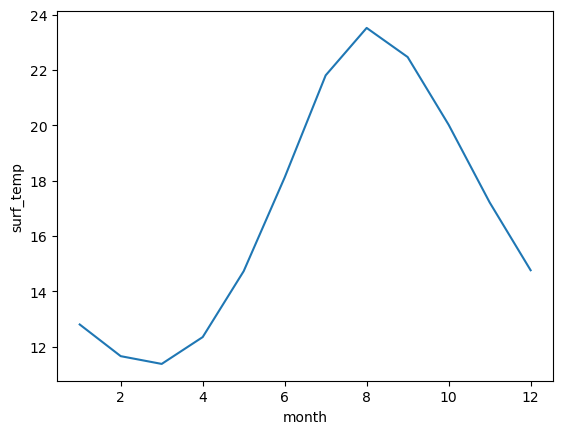

<xarray.Dataset> Size: 14MB
Dimensions:    (month: 12, latitude: 154, longitude: 235)
Coordinates:
  * latitude   (latitude) float32 616B 35.25 35.33 35.42 ... 47.83 47.92 48.0
  * longitude  (longitude) float32 940B -75.75 -75.67 -75.58 ... -56.33 -56.25
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    surf_temp  (month, latitude, longitude) float64 3MB 13.49 13.53 ... nan nan
    bot_temp   (month, latitude, longitude) float64 3MB 13.48 14.5 ... nan nan
    surf_sal   (month, latitude, longitude) float64 3MB 33.87 33.87 ... nan nan
    bot_sal    (month, latitude, longitude) float64 3MB 33.88 34.34 ... nan nan
Attributes:
    title:         GLORYs - Monthly Climatology 1993-2023
    Date Created:  12/31/2024
    Institution:   Gulf  of Maine Research Institute
    grid_type:     mosaic
    CDI:           Climate Data Interface version 1.9.9 (https://mpimet.mpg.d...
    Conventions:   CF-1.6

<Figure size 640x480 with 0 Axes>

In [4]:

####  Subset Years  ####
glorys_slice = glorys_full.sel(time = slice(f"{start_year}-01-01", f"{end_year}-12-31"))

# Use groupby to get average for each month in reference period
months = glorys_slice.time.dt.month # grouping indices
monthly_clim = glorys_slice.groupby(months).mean('time', keep_attrs = True)

# What does the timeline for the whole area look like?:
area_ts = getattr(monthly_clim, "surf_temp").mean(dim = ("longitude", "latitude"))
area_ts.plot()
plt.show()
plt.clf()

####  Save Climatology

# Build out attributes
monthly_clim.attrs = {
  'title'                   : f'GLORYs - Monthly Climatology {start_year}-{end_year}', 
  'Date Created'            : "12/31/2024",
  'Institution'             : "Gulf  of Maine Research Institute",
  'grid_type'               : 'mosaic', 
  'CDI'                     : 'Climate Data Interface version 1.9.9 (https://mpimet.mpg.de/cdi)', 
  'Conventions'             : 'CF-1.6'
}

# Review Climatology
monthly_clim



In [5]:

# save to box
# monthly_clim.to_netcdf(f"{box_root}RES_Data/GLORYs/NW_Atl_MonthlyTemps/Climatology{start_year}to{end_year}.nc")
monthly_clim.to_netcdf(f"{box_root}RES_Data/GLORYs/NW_Atl_MonthlyTemps/TempSalClimatology{start_year}to{end_year}.nc")